## 6.3 교차검증

### 표본내 성능과 표본외 성능

회귀분석 모형을 만들기 위해서는 모수 추정 즉 학습(training)을 위한 데이터 집합이 필요하다. 이 데이터 집합을 학습용 데이터 집합(traning data set)이라고 한다. 이 학습 데이터 집합의 종속 변수값을 얼마나 잘 예측하였는지를 나타내는 성능을 **표본내 성능 검증(in-sample testing)**이라고 한다.

그런데 회귀분석 모형을 만드는 목적 중 하나는 종속 변수의 값을 아직 알지 못하고 따라서 학습에 사용하지 않은 표본의 대해 종속 변수의 값을 알아내고자 하는 것 즉 예측(prediction)이다. 이렇게 학습에 쓰이지 않는 표본 데이터 집합의 종속 변수 값을 얼마나 잘 예측하는가를 검사하는 것을 **표본외 성능 검증(out-of-sample testing)** 혹은 **교차검증(cross validation)**이라고 한다.

### 과최적화

일반적으로 표본내 성능과 표본외 성능은 비슷한 수준을 보이지만 경우에 따라서는 표본내 성능은 좋으면서 표본외 성능이 상대적으로 많이 떨어지는 수도 있다. 이러한 경우를 **과최적화(overfitting)**라고 한다. 과최적화가 발생하면 학습에 쓰였던 표본 데이터에 대해서는 잘 종속 변수의 값을 잘 추정하지만 새로운 데이터를 주었을 때 전혀 예측하지 못하기 때문에 예측 목적으로는 쓸모없는 모형이 된다.

이러한 과최적화가 발생하는 원인과 과최적화를 방지하기 위한 정규화(regularization) 방법에 대해서는 다음 절에서 다룬다. 여기에서는 과최적화가 발생한 것을 탐지하기 위한 교차검증 방법을 공부한다.

### 검증용 데이터 집합

교차검증을 하려면 두 종류의 데이터 집합이 필요하다. 

* 모형 추정 즉 학습을 위한 데이터 집합 (training data set)
* 성능 검증을 위한 데이터 집합 (test data set)

두 데이터 집합 모두 종속 변수값이 있어야 한다. 따라서 보통은 가지고 있는 데이터 집합을 학습용과 검증용으로 나누어 학습용 데이터만을 사용하여 회귀분석 모형을 만들고 검증용 데이터로 성능을 계산하는 **학습/검증 데이터 분리(train-test split)** 방법을 사용한다.

### statsmodels 패키지에서의 교차검증

소수의 입력 변수와 소규모 데이터를 사용하는 전통적인 회귀분석에서는 다항회귀 등의 방법으로 모형 차수를 증가시키지 않는 한 과최적화가 생기는 경우가 드물다. 따라서 statsmodels 패키지에는 교차검증을 위한 기능이 별도로 준비되어 있지 않고 사용자가 직접 코드를 작성해야 한다.

다음은 보스턴 집값 데이터를 학습용과 검증용으로 나누어 교차검증을 하는 코드이다. 우선 무작위로 70%의 데이터를 골라서 학습용 데이터로 하고 나머지를 검증용 데이터로 한다.

In [1]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

N = len(df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

df_train = df.iloc[idx_train]
df_test = df.iloc[idx_test]

학습용 데이터로 회귀모형을 만들면 결정 계수는 0.757이다.

In [2]:
model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     81.31
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           7.22e-96
Time:                        14:43:52   Log-Likelihood:                -1057.6
No. Observations:                 354   AIC:                             2143.
Df Residuals:                     340   BIC:                             2197.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.6105      6.807      5.966      0.0

남겨둔 검증용 데이터로 성능을 구하면 결정계수는 0.688이다.

In [3]:
pred = result.predict(df_test)

rss = ((df_test.MEDV - pred) ** 2).sum()
tss = ((df_test.MEDV - df_test.MEDV.mean())** 2).sum()
rsquared = 1 - rss / tss
rsquared

0.6883734124987108

### scikit-learn의 교차검증 기능

독립 변수의 개수가 많은 빅데이터에서는 과최적화가 쉽게 발생한다. 따라서 scikit-learn 의 model_selection 서브 패키지는 교차검증을 위한 다양한 명령을 제공한다.

### 단순 데이터 분리

`train_test_split` 명령은 데이터를 학습용 데이터와 검증용 데이터로 분리한다. 사용법은 다음과 같다.


```
train_test_split(data, data2, test_size, train_size, random_state)
```

* `data`: 독립 변수 데이터 배열 또는 pandas 데이터프레임
* `data2`: 종속 변수 데이터. `data` 인수에 종속 변수 데이터가 같이 있으면 생략할 수 있다.
* `test_size`: 검증용 데이터 개수. 1보다 작은 실수이면 비율을 나타낸다.
* `train_size`: 학습용 데이터의 개수. 1보다 작은 실수이면 비율을 나타낸다. `test_size`와 `train_size` 중 하나만 있어도 된다.
* `random_state`: 난수 시드


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)
df_train.shape, df_test.shape

((354, 14), (152, 14))

In [5]:
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(dfX, dfy, test_size=0.3, random_state=0)
dfX_train.shape, dfy_train.shape, dfX_test.shape, dfy_test.shape

((354, 13), (354, 1), (152, 13), (152, 1))

### K-폴드 교차검증

데이터의 수가 적은 경우에는 이 데이터 중의 일부인 검증 데이터의 수도 적기 때문에 검증 성능의 신뢰도가 떨어진다. 그렇다고 검증 데이터의 수를 증가시키면 학습용 데이터의 수가 적어지므로 정상적인 학습이 되지 않는다. 이러한 딜레마를 해결하기 위한 검증 방법이 **K-폴드(K-fold)** 교차검증 방법이다.

K-폴드 교차검증에서는 다음처럼 학습과 검증을 반복한다.

1. 전체 데이터를 K개의 부분 집합($\{D_1, D_2,\cdots, D_K\}$)으로 나눈다.
2. 데이터 $\{D_1, D_2, \cdots, D_{K-1} \}$를 학습용 데이터로 사용하여 회귀분석 모형을 만들고 데이터 $\{D_K\}$로 교차검증을 한다.
3. 데이터 $\{D_1, D_2, \cdots, D_{K-2}, D_K \}$를 학습용 데이터로 사용하여 회귀분석 모형을 만들고 데이터 $\{D_{K-1}\}$로 교차검증을 한다.
<br>$\vdots$
4. 데이터 $\{D_2, \cdots, D_K \}$를 학습용 데이터로 사용하여 회귀분석 모형을 만들고 데이터 $\{D_1\}$로 교차검증을 한다.

이렇게 하면 총 K개의 모형과 K개의 교차검증 성능이 나온다. 이 K개의 교차검증 성능을 평균하여 최종 교차검증 성능을 계산한다.


In [1]:
%load_ext tikzmagic

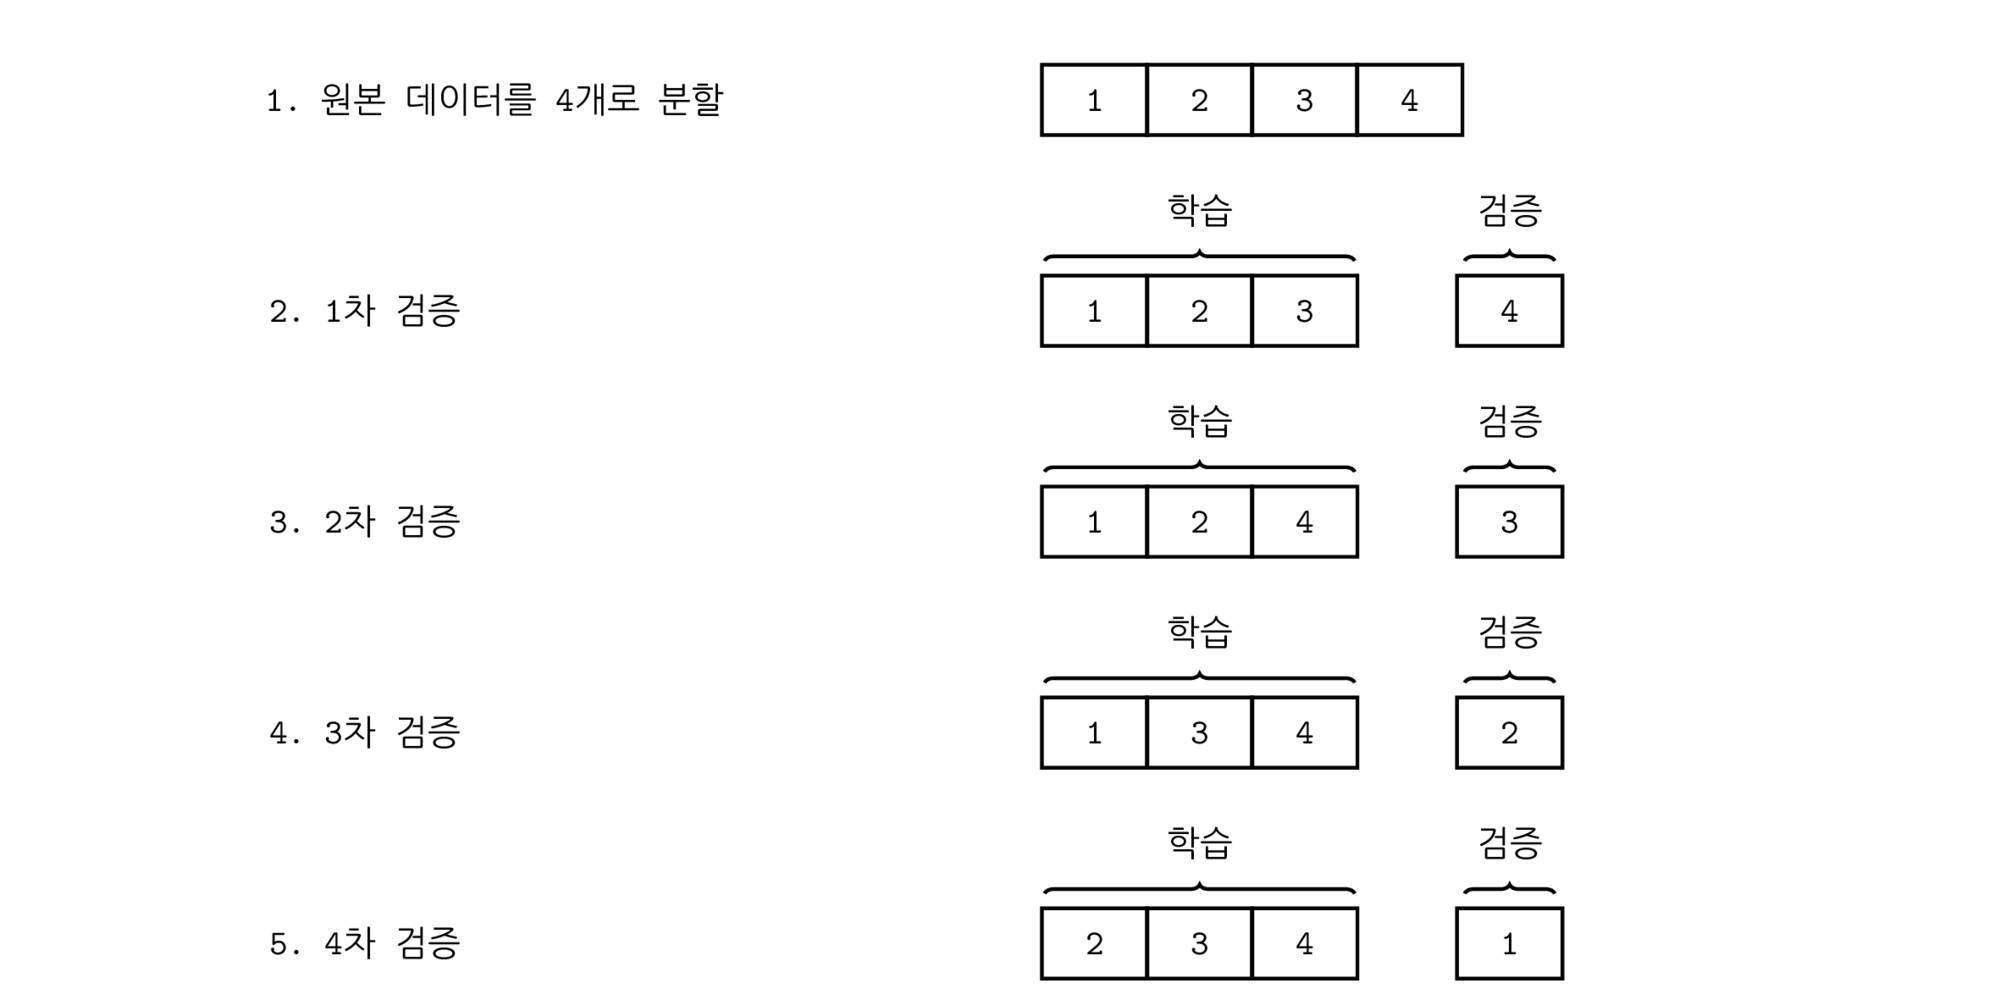

In [3]:
%%tikz -p kotex,pgfplots -l arrows.meta,calc,positioning,shapes -s 2000,2000 -f png

\coordinate (leftbottom) at (-10,0);
\coordinate (righttop) at (10,10);
\fill[white,use as bounding box] (leftbottom) rectangle (righttop);
\draw[help lines,white] (leftbottom) grid (righttop);
\tikzset{
    >=stealth,font={\ttfamily\normalsize}
}

\tikzstyle{block} = [%
draw, shape=rectangle, minimum height=2em, minimum width=3em, node distance=4cm, line width=1pt]

\begin{scope}[xshift=-30]
    \node at(-4,9) {1. 원본 데이터를 4개로 분할};
    \node at(2,9)[block] {1};
    \node at(3.05,9)[block] {2};
    \node at(4.1,9)[block] {3};
    \node at(5.15,9)[block] {4};
    
    \begin{scope}[yshift=-60]
        \node at(-5.3,9) {2. 1차 검증};
        \node at(2,9)[block] {1};
        \node at(3.05,9)[block] {2};
        \coordinate (mid) at (3.05,9);
        \node at(4.1,9)[block] {3};
        \node at(6.15,9)[block] {4};
        \coordinate (end) at (6.15,9);
        \draw[decorate, decoration=brace, line width=1pt] (1.5,9.5) -- (4.6,9.5);
        \node [above of = mid]  {학습};
        \draw[decorate,decoration=brace, line width=1pt] (5.7,9.5) -- (6.6,9.5);
        \node [above of = end]  {검증};
    \end{scope}
    
    \begin{scope}[yshift=-120]
        \node at(-5.3,9) {3. 2차 검증};
        \node at(2,9)[block] {1};
        \node at(3.05,9)[block] {2};
        \coordinate (mid) at (3.05,9);
        \node at(4.1,9)[block] {4};
        \node at(6.15,9)[block] {3};
        \coordinate (end) at (6.15,9);
        \draw[decorate, decoration=brace, line width=1pt] (1.5,9.5) -- (4.6,9.5);
        \node [above of = mid]  {학습};
        \draw[decorate,decoration=brace, line width=1pt] (5.7,9.5) -- (6.6,9.5);
        \node [above of = end]  {검증};
    \end{scope}
    
    \begin{scope}[yshift=-180]
        \node at(-5.3,9) {4. 3차 검증};
        \node at(2,9)[block] {1};
        \node at(3.05,9)[block] {3};
        \coordinate (mid) at (3.05,9);
        \node at(4.1,9)[block] {4};
        \node at(6.15,9)[block] {2};
        \coordinate (end) at (6.15,9);
        \draw[decorate,decoration=brace, line width=1pt] (1.5,9.5) -- (4.6,9.5);
        \node [above of = mid]  {학습};
        \draw[decorate,decoration=brace, line width=1pt] (5.7,9.5) -- (6.6,9.5);
        \node [above of = end]  {검증};
    \end{scope}
    
    \begin{scope}[yshift=-240]
        \node at(-5.3,9) {5. 4차 검증};
        \node at(2,9)[block] {2};
        \node at(3.05,9)[block] {3};
        \coordinate (mid) at (3.05,9);
        \node at(4.1,9)[block] {4};
        \node at(6.15,9)[block] {1};
        \coordinate (end) at (6.15,9);
        \draw[decorate,decoration=brace, line width=1pt] (1.5,9.5) -- (4.6,9.5);
        \node [above of = mid]  {학습};
        \draw[decorate,decoration=brace, line width=1pt] (5.7,9.5) -- (6.6,9.5);
        \node [above of = end]  {검증};
    \end{scope}
\end{scope}

scikit-learn 패키지의 model_selection 서브 패키지는 `KFold` 클래스를 비롯한 다양한 교차검증 생성기를 제공한다. 이 생성기의 `split` 메서드는 
학습용과 검증용의 데이터 인덱스를 출력하는 파이썬 반복자(iterator)를 반환한다.

In [6]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.MEDV - pred) ** 2).sum()
    tss = ((df_test.MEDV - df_test.MEDV.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.77301356, 검증 R2 = 0.58922238
학습 R2 = 0.72917058, 검증 R2 = 0.77799144
학습 R2 = 0.74897081, 검증 R2 = 0.66791979
학습 R2 = 0.75658611, 검증 R2 = 0.66801630
학습 R2 = 0.70497483, 검증 R2 = 0.83953317


### 평가 점수

scikit-learn의 metrics 서브패키지에는 예측 성능을 평가하기 위한 다양한 함수를 제공한다. 그 중 회귀분석에 유용한 함수를 소개한다.

* `r2_score`: 결정 계수
* `mean_squared_error`: 평균 제곱 오차(mean squared error)
* `median_absolute_error`: 절대 오차 중앙값(median absolute error)

이 함수를 이용하여 위 코드를 다음처럼 간단하게 고칠 수 있다.

In [7]:
from sklearn.metrics import r2_score

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rsquared = r2_score(df_test.MEDV, pred)
    
    scores[i] = rsquared

scores

array([0.58922238, 0.77799144, 0.66791979, 0.6680163 , 0.83953317])

### 교차검증 반복

위와 같이 교차검증을 반복하는 코드를 더 간단하게 만들어주는 함수가 있다. 바로 `cross_val_score`이다. 사용법은 다음과 같다.

```
cross_val_score(model, X, y, scoring=None, cv=None)
```

* `model` : 회귀 분석 모형
* `X` : 독립 변수 데이터
* `y` : 종속 변수 데이터
* `scoring` : 성능 검증에 사용할 함수 이름
* `cv` : 교차검증 생성기 객체 또는 숫자.
   * `None`이면 `KFold(3)`
   * 숫자 `k`이면 `KFold(k)`


단 `cross_val_score` 명령은 scikit-learn에서 제공하는 모형만 사용할 수 있다. statsmodels의 모형 객체를 사용하려면 다음과 같이 scikit-learn의 `RegressorMixin`으로 래퍼 클래스(wrapper class)를 만들어주어야 한다.

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)

이 래퍼 클래스와 `cross_val_score` 명령을 사용하면 교차검증 성능 값을 다음처럼 간단하게 계산할 수 있다.

In [9]:
from sklearn.model_selection import cross_val_score

model = StatsmodelsOLS("MEDV ~ " + "+".join(boston.feature_names))
cv = KFold(5, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv)

array([0.58922238, 0.77799144, 0.66791979, 0.6680163 , 0.83953317])

### 벤치마크 검증 데이터

유명한 벤치마크 문제(benchmark problem)나 캐글(Kaggle)과 같은 데이터 분석 경진대회(competition)에서는 최종 성능검증을 위한 검증 데이터가 별도로 제공될 수도 있다. 이렇게 하는 이유는 어떤 K-폴드 등의 방법으로 생성된 검증 데이터가 달라지면 성능도 약간씩 달라질 수 있기 때문에 순위 결정을 위해 어쩔 수 없이 하나의 최종 검증 데이터를 못박아 놓은 것이다. 따라서 이렇게 유일한 검증 데이터에 대한 성능은 엄격한 의미에서 절대적인 것이라고 볼 수 없다. 이러한 경우에도 학습용 데이터를 K-폴드 등의 방법으로 나누어 교차검증을 실시함으로써 과최적화를 막을 수 있다.

이러한 벤치마크 문제에서 최종 검증 데이터를 학습에 사용하는 것은 일종의 반칙(cheating)이므로 절대로 최종 검증 데이터를 학습에 사용해서는 안된다. 캐글과 같은 경진대회에서는 최종 검증 데이터에 대한 종속변수 값은 공개하지 않고 독립변수 값만 공개함으로써 최종 검증 데이터를 학습에 사용하는 것을 막는다.